In [1]:
import os
import sys
import time
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt, ticker
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor, gps, giantTimeseries
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut

work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pysar_vs_gps'
os.chdir(work_dir)
print('Go to directory: '+work_dir)
gps_dir = '/Users/yunjunz/insarlab/Galapagos/GPS'

site_r = 'ISCO' #'ISCO'  'GV01'  'GV07'

pysar_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE'
ts_file = os.path.join(pysar_dir, 'geo_timeseries_ECMWF_demErr_refDate_plane.h5')
ts_obj = timeseries(ts_file)
geom_file = os.path.join(pysar_dir, 'geo_geometryRadar.h5')
ts_obj.open(print_msg=False)
atr = ts_obj.metadata
unit_fac = 1.

num_date = ts_obj.numDate


def read_timeseries(site, site_r=None):
    ## Read GPS
    (gps_times,
     gps_dis,
     gps_std,
     site_lalo,
     ref_site_lalo) = ut.read_gps_los_displacement(site=site,
                                                   gps_dir=gps_dir,
                                                   geom_file=geom_file,
                                                   ref_site=site_r)

    ## Read InSAR
    coord = ut.coordinate(atr, lookup_file=geom_file)
    y, x = coord.geo2radar(site_lalo[0],
                           site_lalo[1],
                           print_msg=False)[0:2]
    box = (x, y, x+1, y+1)
    pysar_dis = readfile.read(ts_file, box=box, print_msg=False)[0] * unit_fac
    pysar_times = ts_obj.times

    if site_r:
        try:
            ref_y, ref_x = coord.geo2radar(ref_site_lalo[0],
                                           ref_site_lalo[1],
                                           print_msg=False)[0:2]
        except:
            ref_y, ref_x = -1, -1
        if 0 <= ref_x < int(atr['WIDTH']) and 0<= ref_y < int(atr['LENGTH']):
            ref_box = (ref_x, ref_y, ref_x+1, ref_y+1)
            pysar_dis -= readfile.read(ts_file, box=ref_box, print_msg=False)[0] * unit_fac

    # common reference date
    comm_idx = 2
    while comm_idx < len(pysar_times):
        if pysar_times[comm_idx] not in gps_times:
            comm_idx += 1
        else:
            break
    if comm_idx == len(pysar_times):
        raise RuntimeError('InSAR and GPS do not share ANY date for site: {}'.format(site))

    comm_date = pysar_times[comm_idx]
    pysar_dis -= pysar_dis[comm_idx]

    comm_idx_gps = np.where(gps_times == comm_date)[0][0]
    gps_dis -= gps_dis[comm_idx_gps]
    gps_std = np.sqrt(gps_std**2 + gps_std[comm_idx_gps]**2)

    # make first insar == 0
    gps_dis -= pysar_dis[0]
    pysar_dis -= pysar_dis[0]

    # cut off gps to match the time range of pysar
    t0 = pysar_times[0] - relativedelta(months=4)
    t1 = pysar_times[-1] + relativedelta(months=4)
    idx = (gps_times >= t0) & (gps_times <= t1)
    gps_times = gps_times[idx]
    gps_dis = gps_dis[idx]
    gps_std = gps_std[idx]

    return gps_times, gps_dis, gps_std, pysar_times, pysar_dis, site_lalo

## Plot
def plot_timeseries(ax, site, gps_times, gps_dis, gps_std,
                    pysar_times, pysar_dis,
                    site_r=None, disp_fig=True, offset=0.):

    #ax.scatter(gps_times, gps_dis-offset, s=1**2, label='GPS', color=pp.mplColors[0])
    (_, caps, _) = ax.errorbar(gps_times, gps_dis-offset, yerr=gps_std*3.,
                               ms=marker_size*0.5, lw=0, alpha=1.,
                               elinewidth=edge_width*0.5,  ecolor=pp.mplColors[0],
                               capsize=marker_size*0.5*0.5, label='GPS', zorder=1)
    for cap in caps:
        cap.set_markeredgewidth(edge_width*0.5)

    ax.scatter(pysar_times, pysar_dis-offset, s=5**2, label='InSAR',
               facecolors='none', edgecolors=pp.mplColors[1], linewidth=1., alpha=0.7, zorder=2)

    ax.annotate('{}-{}'.format(site, site_r), xy=(1.03, pysar_dis[-1] - offset),
                xycoords=ax.get_yaxis_transform(),  # y in data untis, x in axes fraction
                color='k', fontsize=font_size)
    return ax

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pysar_vs_gps


Done.


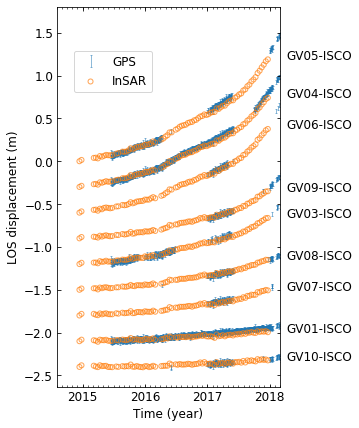

In [2]:
gps_sites = ['GV05', 'GV04', 'GV06', 'GV09', 'GV03', 'GV08', 'GV07', 'GV01', 'GV10']
if site_r in gps_sites:
    gps_sites.remove(site_r)
offset = 0.3

fig, ax = plt.subplots(figsize=(4, 7))
for i in range(len(gps_sites)):
    (gps_times,
     gps_dis,
     gps_std,
     pysar_times,
     pysar_dis) = read_timeseries(site=gps_sites[i], site_r=site_r)[0:5]

    ax = plot_timeseries(ax, gps_sites[i],
                         gps_times, gps_dis, gps_std,
                         pysar_times, pysar_dis,
                         site_r=site_r, disp_fig=False,
                         offset=offset * i)

ax = pp.auto_adjust_xaxis_date(ax, ts_obj.yearList)[0]
ax.set_xlabel('Time (year)', fontsize=font_size)
ax.set_ylabel('LOS displacement (m)', fontsize=font_size)
ax.tick_params(which='both', direction='in', labelsize=font_size,
               bottom=True, top=True, left=True, right=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[-1], handles[0]], [labels[-1], labels[0]],
          loc='upper left', bbox_to_anchor=(0.05, 0.9), fontsize=font_size)
print('Done.')

plt.savefig('insar_vs_gps_point_ts_{}.jpg'.format(site_r), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

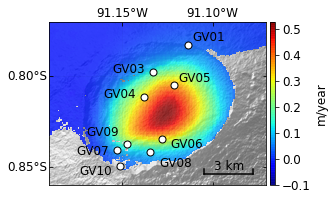

In [3]:
## map inset to show InSAR velocity field with GPS location on Sierra Negra
pysar_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE'
vel_file = os.path.join(pysar_dir, 'geo_velocity_masked.h5')
dem_file = os.path.join(pysar_dir, '../../DEM/demLat_S02_N01_Lon_W092_W090.dem.wgs84')

print_msg = False
#ax2 = fig.add_axes([0.1, 0.77, 0.8, 0.2])
fig, ax2 = plt.subplots(figsize=(5, 3))


# call view.py functions to plot InSAR background
from pysar import view
view_cmd = ('view.py {vf} velocity -l -0.86 -0.77 -L -91.19 -91.07 --mask no '
            '--dem {df} --dem-nocontour '
            '-u m --lalo-step 0.05 --lalo-loc 1 0 1 0 --scalebar 3000 -0.854 -91.091 --figsize 4 2.5 '
            '-s 12 --notitle --dpi 600 -m -0.1 --cbar-nbins 7').format(vf=vel_file, df=dem_file)

inps = view.cmd_line_parse(view_cmd.split()[1:])
inps, atr = view.check_input_file_info(inps, print_msg=print_msg)
inps = view.update_inps_with_file_metadata(inps, atr, print_msg=print_msg)
data, atr = view.readfile.read(inps.file,
                               datasetName=inps.dset[0],
                               box=inps.pix_box,
                               print_msg=print_msg)
ax2, inps, im = view.plot_2d_matrix(ax2, data, atr, inps, print_msg=print_msg)


# plot GPS location with its label
gps_sites = ['GV{:02d}'.format(i) for i in [1] + np.arange(3,11).tolist()]
lat_off = np.array([1,  0,  0,  1, -2,  -1, -3,   2,  -2]) * 0.05 / 20.
lon_off = np.array([1, -9, -9,  1,  2,  -9,  2,  -9,  -9]) * 0.05 / 20.

gps_lats = []
gps_lons = []
for site in gps_sites:
    lat, lon = gps(site=site, data_dir=gps_dir).get_stat_lat_lon(print_msg=print_msg)
    gps_lats.append(lat)
    gps_lons.append(lon)
ax2.scatter(gps_lons, gps_lats, s=7**2, color='w', edgecolors='k')
for i in range(len(gps_sites)):
    ax2.annotate(gps_sites[i],
                 (gps_lons[i]+lon_off[i],
                  gps_lats[i]+lat_off[i]),
                 fontsize=font_size)

plt.savefig('insar_vs_gps_map.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()